## 1. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [2]:
# Install XGBoost if needed
try:
    import xgboost as xgb
    print("✅ XGBoost already installed")
    print(f"Version: {xgb.__version__}")
except ImportError:
    print("Installing XGBoost...")
    !pip install xgboost
    import xgboost as xgb
    print("✅ XGBoost installed successfully!")

Installing XGBoost...
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB 660.6 kB/s eta 0:01:49
   ---------------------------------------- 0.3/72.0 MB 4.2 MB/s eta 0:00:18
   - -------------------------------------- 3.0/72.0 MB 23.6 MB/s eta 0:00:03
   ---- ----------------------------------- 7.6/72.0 MB 48.9 MB/s eta 0:00:02
   ------- -------------------------------- 13.8/72.0 MB 110.0 MB/s eta 0:00:01
   ---------- ----------------------------- 19.3/72.0 MB 131.2 MB/s eta 0:00:01
   ------------- -------------------------- 24.9/72.0 MB 108.8 MB/s eta 0:00:01
   ---------------- ----------------------- 30.3/72.0 MB 108.8 MB/s eta 0:00:01
   ------------------- -------------------- 35.7/72.0 MB 108.8 MB/s eta 0:00:01
   ---------------------- ----------------- 41.2/72.0 MB 108.8 MB/s eta 0:00:01
   -------------------------- ------------- 46.8/72.0 MB 108.8 MB/s eta 0:00:01
   ----------------------------- ---


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\Saim\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
# Load preprocessed data
df = pd.read_csv('preprocessed_final.csv')
df['date'] = pd.to_datetime(df['date'])

print(f"Dataset loaded: {df.shape}")
print(f"Date range: {df['date'].min().date()} to {df['date'].max().date()}")
df.head()

Dataset loaded: (1785, 68)
Date range: 1996-06-13 to 2020-02-27


,date,next_trading_day,speaker,Positive,Negative,Polarity,LM_pos_rate,LM_neg_rate,LM_net_polarity_per_token,fomc_hawk,...,target_NDQ_1d,target_NDQ_5d,class_SP500_1d,class_SP500_5d,class_RSL_1d,class_RSL_5d,class_DJIA_1d,class_DJIA_5d,class_NDQ_1d,class_NDQ_5d
0,1996-12-19,1996-12-20,Vice Chair Alice M. Rivlin,50,88,-0.275362,0.029638,0.052164,-0.022525,0.000294,...,-0.003616,0.009195,Neutral,Neutral,Neutral,Neutral,Bearish,Neutral,Neutral,Neutral
1,1996-12-06,1996-12-09,Chairman Alan Greenspan,59,70,-0.085271,0.046975,0.055732,-0.008758,0.099280,...,0.002247,-0.027768,Neutral,Bearish,Neutral,Bearish,Bearish,Bearish,Neutral,Bearish
2,1996-12-05,1996-12-06,Chairman Alan Greenspan,62,137,-0.376884,0.033550,0.074134,-0.040584,0.002163,...,0.014037,-0.003713,Bullish,Bearish,Bullish,Bearish,Bullish,Neutral,Bullish,Neutral
3,1996-12-03,1996-12-04,"Governor Edward W. Kelley, Jr.",36,59,-0.242105,0.028916,0.047390,-0.018474,0.000181,...,0.002653,-0.001117,Neutral,Neutral,Neutral,Neutral,Neutral,Bullish,Neutral,Neutral
4,1996-11-25,1996-11-26,Governor Susan M. Phillips,52,32,0.238095,0.047575,0.029277,0.018298,0.000161,...,0.003671,0.019125,Neutral,Bearish,Neutral,Bearish,Neutral,Neutral,Neutral,Bullish


## 2. Prepare Features and Target

In [4]:
# Define columns
metadata_cols = ['date', 'next_trading_day', 'speaker']
target_cols = [c for c in df.columns if c.startswith('target_') or c.startswith('class_')]
feature_cols = [c for c in df.columns if c not in metadata_cols + target_cols]

print(f"Features: {len(feature_cols)}")
print(f"Targets: {len(target_cols)}")

Features: 49
Targets: 16


In [5]:
# Primary target: S&P 500 next-day classification
primary_target = 'class_SP500_1d'

X = df[feature_cols].copy()
y = df[primary_target].copy()

# Encode target labels
label_mapping = {'Bearish': 0, 'Neutral': 1, 'Bullish': 2}
y_encoded = y.map(label_mapping)

print(f"\nTarget distribution:")
print(y.value_counts())
print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y_encoded.shape}")


Target distribution:
class_SP500_1d
Neutral    911
Bullish    491
Bearish    383
Name: count, dtype: int64

Features shape: (1785, 49)
Target shape: (1785,)


## 3. Train-Test Split (Time-Based)

In [6]:
# 80/20 split, preserving temporal order
split_index = int(len(df) * 0.8)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y_encoded.iloc[:split_index]
y_test = y_encoded.iloc[split_index:]

train_dates = df['date'].iloc[:split_index]
test_dates = df['date'].iloc[split_index:]

print(f"Training: {len(X_train)} samples ({train_dates.min().date()} to {train_dates.max().date()})")
print(f"Testing: {len(X_test)} samples ({test_dates.min().date()} to {test_dates.max().date()})")
print(f"\nTraining class distribution:\n{y_train.value_counts().sort_index()}")
print(f"\nTest class distribution:\n{y_test.value_counts().sort_index()}")

Training: 1428 samples (1996-06-13 to 2013-12-16)
Testing: 357 samples (2013-01-04 to 2020-02-27)

Training class distribution:
class_SP500_1d
0    338
1    679
2    411
Name: count, dtype: int64

Test class distribution:
class_SP500_1d
0     45
1    232
2     80
Name: count, dtype: int64


## 4. Baseline Model

In [7]:
# Baseline: Always predict most common class
most_common_class = y_train.mode()[0]
baseline_pred = np.full(len(y_test), most_common_class)
baseline_acc = accuracy_score(y_test, baseline_pred)

print(f"Baseline: Always predict class {most_common_class}")
print(f"Baseline Accuracy: {baseline_acc:.4f}")
print(f"\n🎯 This is the performance to beat!")

Baseline: Always predict class 1
Baseline Accuracy: 0.6499

🎯 This is the performance to beat!


## 5. Train XGBoost

In [8]:
# Train XGBoost model
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='mlogloss',
    use_label_encoder=False
)

print("Training XGBoost...")
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)
print("✅ Training complete!")

Training XGBoost...
✅ Training complete!


## 6. Evaluate Performance

In [9]:
# Make predictions
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)

# Calculate metrics
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("="*60)
print("XGBOOST RESULTS")
print("="*60)
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"\nBaseline:  {baseline_acc:.4f}")
print(f"Improvement: {(acc - baseline_acc)*100:.2f}%")
print("="*60)

XGBOOST RESULTS
Accuracy:  0.5574
Precision: 0.4850
Recall:    0.5574
F1 Score:  0.5128

Baseline:  0.6499
Improvement: -9.24%


In [10]:
# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Bearish', 'Neutral', 'Bullish'], zero_division=0))


Detailed Classification Report:
              precision    recall  f1-score   support

     Bearish       0.20      0.11      0.14        45
     Neutral       0.66      0.81      0.72       232
     Bullish       0.15      0.09      0.11        80

    accuracy                           0.56       357
   macro avg       0.34      0.33      0.33       357
weighted avg       0.48      0.56      0.51       357



## 7. Confusion Matrix

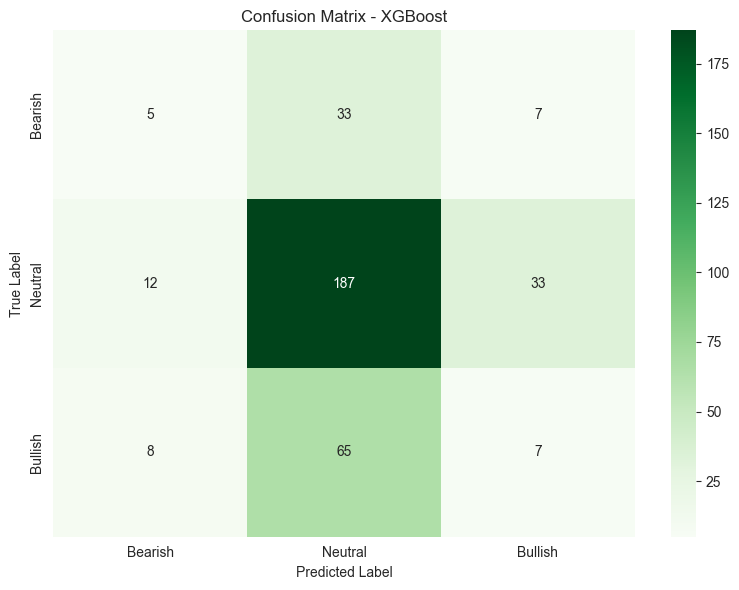

Confusion Matrix:
[[  5  33   7]
 [ 12 187  33]
 [  8  65   7]]


In [11]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Bearish', 'Neutral', 'Bullish'],
            yticklabels=['Bearish', 'Neutral', 'Bullish'])
plt.title('Confusion Matrix - XGBoost')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print("Confusion Matrix:")
print(cm)

## 8. Feature Importance

In [12]:
# Get feature importance
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
print(importance_df.head(20).to_string(index=False))

Top 20 Most Important Features:
              feature  importance
          RSL_ret_20d    0.036098
           RSL_ret_5d    0.035011
          DJIA_ret_5d    0.031058
         DJIA_vol_20d    0.031044
        SP500_vol_20d    0.028404
         SP500_ret_1d    0.027309
           NDQ_ret_5d    0.027091
          RSL_vol_20d    0.027022
           RSL_ret_1d    0.025557
           NDQ_ret_1d    0.024672
         DJIA_ret_20d    0.023939
        SP500_ret_20d    0.023758
          DJIA_ret_1d    0.023670
          NDQ_ret_20d    0.022845
         SP500_ret_5d    0.022708
                month    0.022585
finbert_label_encoded    0.022151
          NDQ_vol_20d    0.021928
                 year    0.021900
         unemployment    0.021835


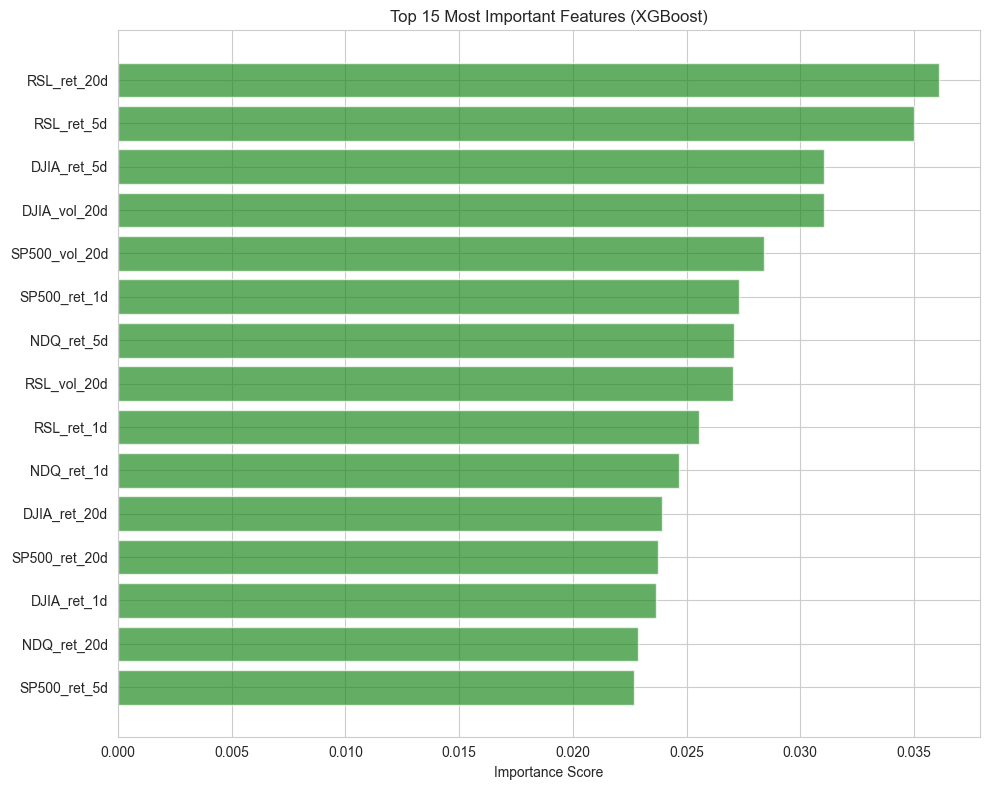

In [13]:
# Visualize top 15 features
plt.figure(figsize=(10, 8))
top_15 = importance_df.head(15)
plt.barh(range(len(top_15)), top_15['importance'], color='forestgreen', alpha=0.7)
plt.yticks(range(len(top_15)), top_15['feature'])
plt.xlabel('Importance Score')
plt.title('Top 15 Most Important Features (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

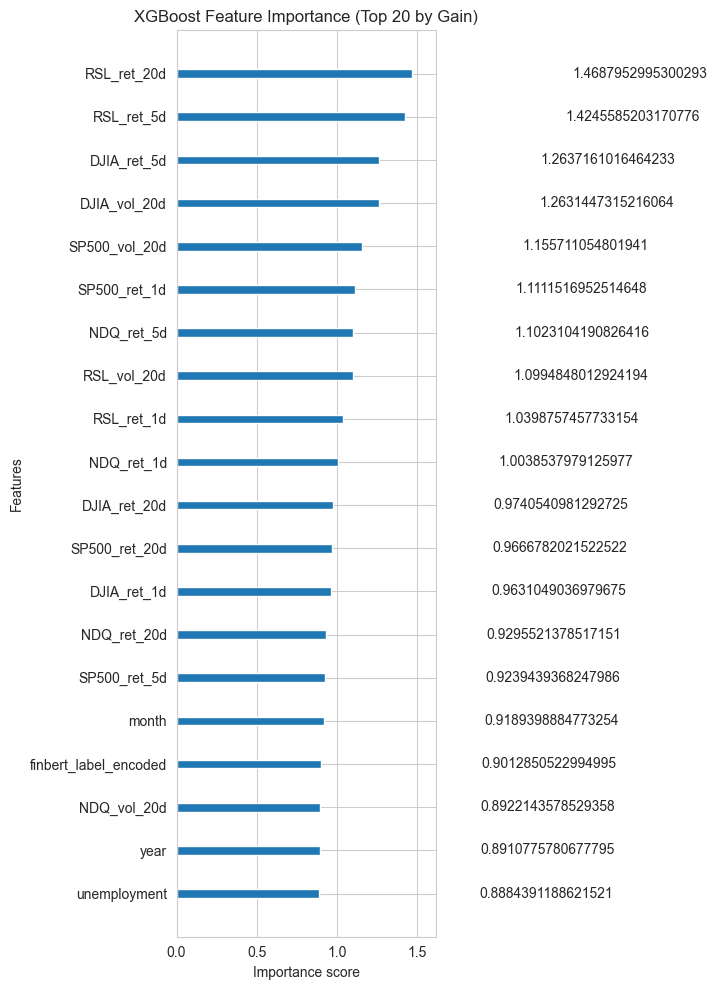

In [14]:
# Plot XGBoost built-in feature importance
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(10, 10))
plot_importance(xgb_model, ax=ax, max_num_features=20, importance_type='gain')
plt.title('XGBoost Feature Importance (Top 20 by Gain)')
plt.tight_layout()
plt.show()

## 9. Time Series Cross-Validation

In [15]:
# Perform 5-fold time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

print("Performing Time Series Cross-Validation...\n")

cv_scores = []
fold_num = 1

for train_idx, val_idx in tscv.split(X):
    X_train_cv = X.iloc[train_idx]
    X_val_cv = X.iloc[val_idx]
    y_train_cv = y_encoded.iloc[train_idx]
    y_val_cv = y_encoded.iloc[val_idx]
    
    # Train model
    xgb_cv = xgb.XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='mlogloss',
        use_label_encoder=False
    )
    xgb_cv.fit(X_train_cv, y_train_cv, verbose=False)
    
    # Evaluate
    y_pred_cv = xgb_cv.predict(X_val_cv)
    acc_cv = accuracy_score(y_val_cv, y_pred_cv)
    f1_cv = f1_score(y_val_cv, y_pred_cv, average='weighted', zero_division=0)
    
    cv_scores.append({'fold': fold_num, 'accuracy': acc_cv, 'f1': f1_cv})
    print(f"Fold {fold_num}: Accuracy = {acc_cv:.4f}, F1 = {f1_cv:.4f}")
    fold_num += 1

cv_df = pd.DataFrame(cv_scores)
print(f"\n{'='*60}")
print(f"Cross-Validation Summary:")
print(f"Mean Accuracy: {cv_df['accuracy'].mean():.4f} (+/- {cv_df['accuracy'].std():.4f})")
print(f"Mean F1 Score: {cv_df['f1'].mean():.4f} (+/- {cv_df['f1'].std():.4f})")
print(f"{'='*60}")

Performing Time Series Cross-Validation...

Fold 1: Accuracy = 0.4276, F1 = 0.3793
Fold 2: Accuracy = 0.5051, F1 = 0.5096
Fold 3: Accuracy = 0.4949, F1 = 0.4342
Fold 4: Accuracy = 0.5185, F1 = 0.4552
Fold 5: Accuracy = 0.6128, F1 = 0.5727

Cross-Validation Summary:
Mean Accuracy: 0.5118 (+/- 0.0665)
Mean F1 Score: 0.4702 (+/- 0.0739)


## 10. Learning Curve

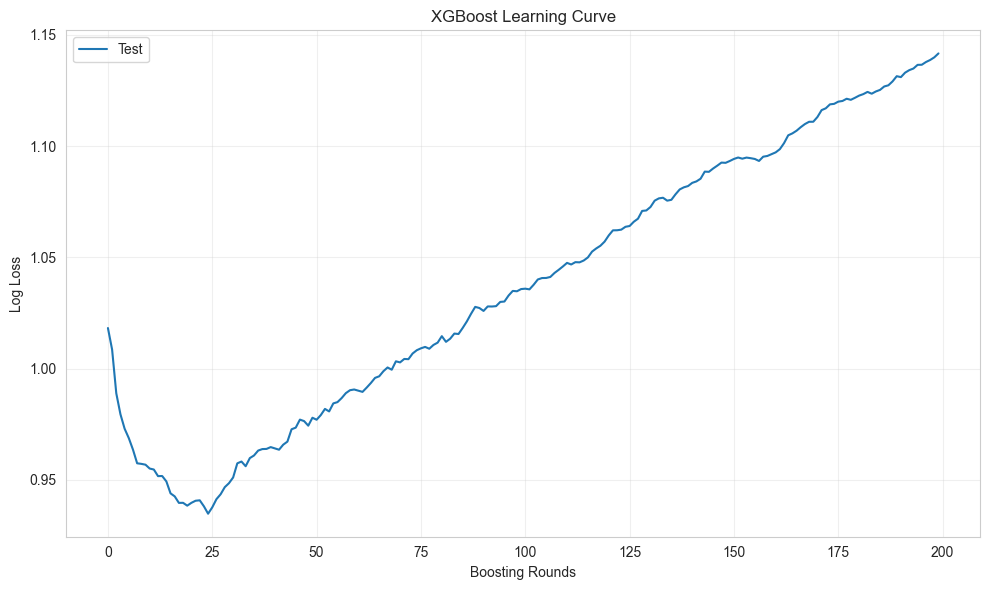

In [16]:
# Get evaluation results from training
results = xgb_model.evals_result()

if results:
    plt.figure(figsize=(10, 6))
    epochs = len(results['validation_0']['mlogloss'])
    x_axis = range(0, epochs)
    
    plt.plot(x_axis, results['validation_0']['mlogloss'], label='Test')
    plt.xlabel('Boosting Rounds')
    plt.ylabel('Log Loss')
    plt.title('XGBoost Learning Curve')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No evaluation results available")

## 11. Save Results

In [17]:
# Save predictions
test_results = df.iloc[split_index:].copy()
test_results['true_class'] = y_test
test_results['predicted_class'] = y_pred
test_results['correct'] = (y_test == y_pred).astype(int)

# Add probability scores
test_results['prob_bearish'] = y_pred_proba[:, 0]
test_results['prob_neutral'] = y_pred_proba[:, 1]
test_results['prob_bullish'] = y_pred_proba[:, 2]

predictions_df = test_results[[
    'date', 'speaker', 'true_class', 'predicted_class', 'correct',
    'prob_bearish', 'prob_neutral', 'prob_bullish'
]]
predictions_df.to_csv('xgboost_predictions.csv', index=False)
print("✅ Predictions saved: xgboost_predictions.csv")

# Save feature importance
importance_df.to_csv('xgboost_feature_importance.csv', index=False)
print("✅ Feature importance saved: xgboost_feature_importance.csv")

# Save model
xgb_model.save_model('xgboost_model.json')
print("✅ Model saved: xgboost_model.json")

✅ Predictions saved: xgboost_predictions.csv
✅ Feature importance saved: xgboost_feature_importance.csv
✅ Model saved: xgboost_model.json


## 12. Summary

In [18]:
print("="*80)
print("XGBOOST - FINAL SUMMARY")
print("="*80)
print(f"\n📊 Model: XGBoost Classifier")
print(f"🎯 Target: S&P 500 Next-Day Direction (Bearish/Neutral/Bullish)")
print(f"\n📈 Performance:")
print(f"  - Test Accuracy: {acc:.4f}")
print(f"  - Baseline: {baseline_acc:.4f}")
print(f"  - Improvement: {(acc - baseline_acc)*100:.2f}%")
print(f"  - F1 Score: {f1:.4f}")
print(f"\n🔄 Cross-Validation:")
print(f"  - Mean Accuracy: {cv_df['accuracy'].mean():.4f}")
print(f"  - Std: {cv_df['accuracy'].std():.4f}")
print(f"\n🌟 Top 3 Features:")
for i, row in importance_df.head(3).iterrows():
    print(f"  {i+1}. {row['feature']}: {row['importance']:.4f}")
print(f"\n💡 Interpretation:")
if acc > baseline_acc + 0.05:
    print("  ✅ Model shows strong predictive power!")
elif acc > baseline_acc:
    print("  ⚠️  Weak signal detected.")
else:
    print("  ❌ No improvement over baseline.")
print("\n" + "="*80)

XGBOOST - FINAL SUMMARY

📊 Model: XGBoost Classifier
🎯 Target: S&P 500 Next-Day Direction (Bearish/Neutral/Bullish)

📈 Performance:
  - Test Accuracy: 0.5574
  - Baseline: 0.6499
  - Improvement: -9.24%
  - F1 Score: 0.5128

🔄 Cross-Validation:
  - Mean Accuracy: 0.5118
  - Std: 0.0665

🌟 Top 3 Features:
  28. RSL_ret_20d: 0.0361
  27. RSL_ret_5d: 0.0350
  31. DJIA_ret_5d: 0.0311

💡 Interpretation:
  ❌ No improvement over baseline.

